In [1]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import time
import sys
import os
import h5py
from os import listdir
from os.path import isfile, join
from sklearn.decomposition import PCA
from scipy import signal

In [2]:
def get_csi(x):
    x = np.squeeze(x["csi_trace"])
    data = []
    for i in range(x.shape[0]):
        array = {}
        array["timestamp_low"] = np.squeeze(x[i][0][0][0])
        array["bfee_count"] =  np.squeeze(x[i][0][0][1])
        array["Nrx"] = np.squeeze(x[i][0][0][2])
        array["Ntx"] = np.squeeze(x[i][0][0][3])
        array["rssi_a"] = np.squeeze(x[i][0][0][4])
        array["rssi_b"] = np.squeeze(x[i][0][0][5])
        array["rssi_c"] = np.squeeze(x[i][0][0][6])
        array["noise"] = np.squeeze(x[i][0][0][7])
        array["agc"] = np.squeeze(x[i][0][0][8])
        array["perm"] = np.squeeze(x[i][0][0][9])
        array["rate"] = np.squeeze(x[i][0][0][10])
        array["csi"] = np.squeeze(x[i][0][0][11])
        
        data.append(array)
    return data

def phase_correction(ph_raw):
    m = np.arange(-28,29)
    Tp = np.unwrap(ph_raw)
    k_param = (Tp[29] - Tp[0])/(m[29] - m[0]);
    b_param = np.sum(Tp)*(1/30)

    correct_phase = []
    for i in range(30):
        correct_phase.append(Tp[i] - k_param*m[i] - b_param)
    return correct_phase

# 3 x 3 MIMO Matrix format
# [h11 h12 h13
# h21 h22 h23
# h31 h32 h33]
def apply_phcorrect(ph_raw):
    mimo_mat = np.rollaxis(ph_raw, 2, 0)
    mimo_mat = np.reshape(mimo_mat, (30, 9))

    crct_ph = []
    for col in range(9):
        crct_ph.append(phase_correction(np.array(mimo_mat)[:, col]))

    stack_crc_ph = np.vstack(crct_ph).T

    restore_ph_mat = []
    for i in range(30):
        restore_ph_mat.append(stack_crc_ph[i, :].reshape((3,3)))
    return np.array(restore_ph_mat).T

def power_delay_profile(data, keep_bins=10):
    data = np.concatenate([np.zeros_like(data[..., 0:1]), data, np.expand_dims(data[..., -1], axis=-1)], axis=-1)
    pdf = np.fft.irfft(data, axis=-1)
    pdf[..., keep_bins:] = 0
    return np.fft.fft(pdf, n=(data.shape[-1]*2)+2, axis=-1)[..., 1:data.shape[-1]-1]

def fill_gaps(csi_trace, technique):
    amp_data = []
    ph_data = []

    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]

        scaled_csi = power_delay_profile(get_scaled_csi(csi_entry))
        amp = np.absolute(scaled_csi)
        ph = np.angle(scaled_csi)

        amp_temp=[]
        ph_temp=[]

        if technique == 'fill':
            if csi_trace[ind]['Ntx'] == 1:
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())

        elif technique == 'mean':
            if csi_trace[ind]['Ntx'] == 1:
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)

                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)

                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())

    return np.hstack([amp_data, ph_data])

def dbinv(x):
    return np.power(10, (np.array(x)/10))

def get_total_rss(csi_st):
    rssi_mag = 0;
    if csi_st['rssi_a'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_a'])

    if csi_st['rssi_b'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_b'])

    if csi_st['rssi_c'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_c'])

    return 10*np.log10(rssi_mag) - 44 - csi_st['agc']

def get_scaled_csi(csi_st):
    csi = csi_st['csi']

    csi_sq = np.multiply(csi, np.conj(csi))
    csi_pwr = np.sum(csi_sq[:])
    rssi_pwr = dbinv(get_total_rss(csi_st))

    scale = rssi_pwr / (csi_pwr / 30)

    if (csi_st['noise'] == -127):
        noise_db = -92
    else:
        noise_db = csi_st['noise']

    thermal_noise_pwr = dbinv(noise_db)
    quant_error_pwr = scale * (csi_st['Nrx'] * csi_st['Ntx'])
    total_noise_pwr = thermal_noise_pwr + quant_error_pwr;

    ret = csi * np.sqrt(scale / total_noise_pwr);
    if csi_st['Ntx'] == 2:
        ret = ret * np.sqrt(2);
    elif csi_st['Ntx'] == 3:
        ret = ret * np.sqrt(dbinv(4.5));

    return ret

def read_samples(dataset_path, endswith=".csv"):
    datapaths, labels = list(), list()
    label = 0
    classes = sorted(os.walk(dataset_path).__next__()[1])

    # List each sub-directory (the classes)
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        # Add each image to the training set
        for sample in walk[2]:
            # Only keeps csv samples
            if sample.endswith(endswith):
                datapaths.append(os.path.join(c_dir, sample))
                labels.append(label)
        label += 1

    return datapaths, labels, classes

def smooth(x,window_len):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=np.hanning(window_len)
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]

def compute_data(file_path, sampling, cols1, cols2):
    if (not os.path.isfile(file_path)):
        raise ValueError("File dosn't exits")

    csi_trace = get_csi(loadmat(file_path))[2000:10000]
    csi_trace = csi_trace[::sampling]
    csi_trace = fill_gaps(csi_trace, technique='mean')[:, cols1:cols2]

    return csi_trace.astype(np.float32)

def get_spectrogram(pca_data):
    f,t,s = signal.spectrogram(pca_data[:, 0], 
                        fs=2000, 
                        window=signal.windows.gaussian(1024, (1024-1)/5), 
                        nperseg=1024, 
                        noverlap=986, 
                        nfft=1024) 
    for k in range(1, pca_data.shape[-1]):
        f1,t1,s1 = signal.spectrogram(pca_data[:, k], 
                            fs=2000, 
                            window=signal.windows.gaussian(1024, (1024-1)/5), 
                            nperseg=1024, 
                            noverlap=986, 
                            nfft=1024)  
        s+=s1
    return s

In [3]:
test1 = get_csi(loadmat("/home/kjakkala/neuralwave/data/Backup/champ_original_1/pp11.mat"))
print(len(test1))

12144


In [5]:
test_data = fill_gaps(test1, "mean")


In [6]:
np.savetxt("csi_data.csv", test_data, delimiter=",")


In [201]:
for i in range(test_data.shape[1]):
    test_data[:, i] = smooth(test_data[:, i], 9)
pca = PCA(n_components=5)
pca_data = pca.fit_transform(test_data)

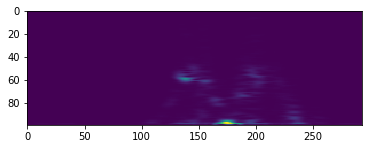

In [202]:
f,t,s = signal.spectrogram(pca_data[:, 0], 
                        fs=2000, 
                        window=signal.windows.gaussian(1024, (1024-1)/5), 
                        nperseg=1024, 
                        noverlap=986, 
                        nfft=1024) 
for i in range(1, 5):
    f1,t1,s1 = signal.spectrogram(pca_data[:, i], 
                            fs=1000, 
                            window=signal.windows.gaussian(1024, (1024-1)/5), 
                            nperseg=1024, 
                            noverlap=986, 
                            nfft=1024) 
    s+=s1
plt.imshow(np.flip(s[:100, :]))

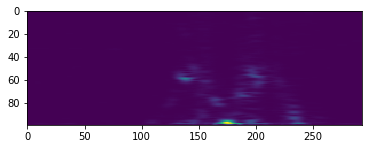

In [81]:
f,t,s = signal.spectrogram(pca_data[:, 0], 
                        fs=2000, 
                        window=signal.windows.gaussian(1024, (1024-1)/5), 
                        nperseg=1024, 
                        noverlap=986, 
                        nfft=1024) 
for i in range(1, 5):
    f1,t1,s1 = signal.spectrogram(pca_data[:, i], 
                            fs=1000, 
                            window=signal.windows.gaussian(1024, (1024-1)/5), 
                            nperseg=1024, 
                            noverlap=986, 
                            nfft=1024) 
    s+=s1
plt.imshow(np.flip(s[:100, :]))

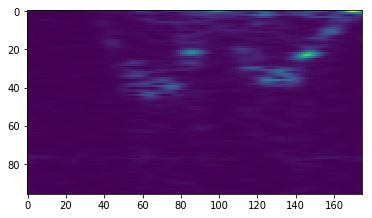

In [53]:
f,t,s = signal.spectrogram(pca_data[:, 0], 
                        fs=2000, 
                        window=signal.windows.gaussian(1024, (1024-1)/5), 
                        nperseg=1024, 
                        noverlap=986, 
                        nfft=1024) 
for i in range(1, 5):
    f1,t1,s1 = signal.spectrogram(pca_data[:, i], 
                            fs=1000, 
                            window=signal.windows.gaussian(1024, (1024-1)/5), 
                            nperseg=1024, 
                            noverlap=986, 
                            nfft=1024) 
    s+=s1
plt.imshow(s[4:100, 25:200])

In [ ]:
def get_spectrogram(pca_data):
    f,t,s = signal.spectrogram(pca_data[:, 0], 
                        fs=2000, 
                        window=signal.windows.gaussian(1024, (1024-1)/5), 
                        nperseg=1024, 
                        noverlap=986, 
                        nfft=1024, 
                        mode='complex') 
    x=np.zeros((80, t.shape[0]))
    for k in range(1, pca_data.shape[-1]):
        f,t,s = signal.spectrogram(pca_data[:, k], 
                            fs=2000, 
                            window=signal.windows.gaussian(1024, (1024-1)/5), 
                            nperseg=1024, 
                            noverlap=986, 
                            nfft=1024, 
                            mode='complex')         
        s_magnitude=np.abs(s)
        s_first80=s_magnitude[:80, :]
        s_enery_level=np.sum(s_first80)
        a_magnitude_norm=s_first80/s_enery_level
        s_magnitude_mean=np.mean(a_magnitude_norm, axis=-1)
        s_magnitude_denoise=(a_magnitude_norm.T-s_magnitude_mean).T
        index=np.where(s_magnitude_denoise < 0)
        s_magnitude_denoise[index]=0
        x+=s_magnitude_denoise
    return x

In [67]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(test1)
pca_data = pca.inverse_transform(pca_data)
print(pca_data.shape)

(12142, 540)


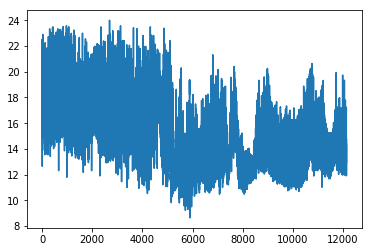

In [54]:
plt.plot(pca_data[:, 0])

In [11]:
print(pca_data.shape)

(12142, 20)


In [21]:
s_tmp = np.zeros((129, 54))
for i in range(20):
    f,t,s = signal.spectrogram(pca_data[:, i], fs=2000) 
    s_tmp += s
print(s.shape)

(129, 54)


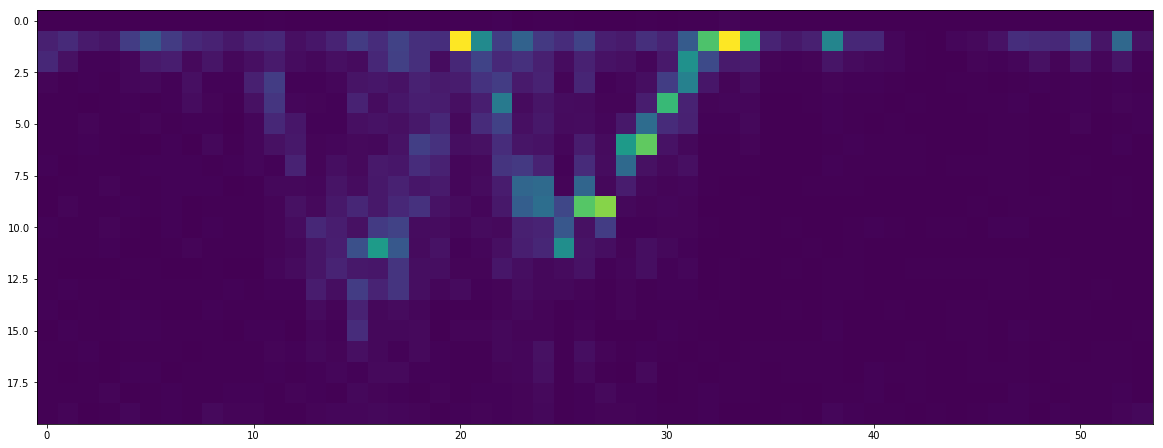

In [24]:
plt.figure(figsize=(20, 20))
plt.imshow(s_tmp[:20])

In [ ]:
data_file = '/home/kjakkala/neuralwave/data/CSI_preprocessed_48_pdf_15.h5'
intruder_dir="/home/kjakkala/neuralwave/data/CSI_INTRUDER_48_pdf_15.h5"
num_classes = 48

hf = h5py.File(data_file, 'r')
X_train = np.expand_dims(hf.get('X_train'), axis=-1)[:, :, ::2]
X_test = np.expand_dims(hf.get('X_test'), axis=-1)[:, :, ::2]
y_train = np.eye(num_classes)[hf.get('y_train')]
y_test = np.eye(num_classes)[hf.get('y_test')]
y_train_n = np.array(hf.get('y_train'))
y_test_n = np.array(hf.get('y_test'))
train_classes = np.array(hf.get('labels')).astype(str)
hf.close()

hf = h5py.File(intruder_dir, 'r')
X_data = np.expand_dims(hf.get('X_data'), axis=-1)[:, :, ::2]
y_data = np.array(hf.get('y_data'))
data_classes = np.array(hf.get('labels')).astype(str)
hf.close() 

print(X_test.shape, data_classes)

In [ ]:
def get_spectrogram(pca_data):
    f,t,s = signal.spectrogram(pca_data[:, 0], 
                        fs=2000, 
                        window=signal.windows.gaussian(1024, (1024-1)/5), 
                        nperseg=1024, 
                        noverlap=986, 
                        nfft=1024, 
                        mode='complex') 
    x=np.zeros((80, t.shape[0]))
    for k in range(1, pca_data.shape[-1]):
        f,t,s = signal.spectrogram(pca_data[:, k], 
                            fs=2000, 
                            window=signal.windows.gaussian(1024, (1024-1)/5), 
                            nperseg=1024, 
                            noverlap=986, 
                            nfft=1024, 
                            mode='complex')         
        s_magnitude=np.abs(s)
        s_first80=s_magnitude[:80, :]
        s_enery_level=np.sum(s_first80)
        a_magnitude_norm=s_first80/s_enery_level
        s_magnitude_mean=np.mean(a_magnitude_norm, axis=-1)
        s_magnitude_denoise=(a_magnitude_norm.T-s_magnitude_mean).T
        index=np.where(s_magnitude_denoise < 0)
        s_magnitude_denoise[index]=0
        x+=s_magnitude_denoise
    return x

def parallel(wavelength, b, a, c, v):
    t_theory=np.linspace(-2, 9, 1000)
    ds=((a-v*t_theory)*(-v)/np.sqrt(b**2+(a-v*t_theory)**2))+((c-v*t_theory)*(-v)/np.sqrt(b**2+(c-v*t_theory)**2))
    f_theory=np.abs(ds/wavelength)
    return t_theory, f_theory

def perpendicular(wavelength, b, a, v):
    t_theory=np.linspace(0, 4.5, 1000)
    ds=(a-v*t_theory)*(-v)/np.sqrt(b**2+(a-v*t_theory)**2)
    f_theory=np.abs(ds/wavelength)
    return t_theory, f_theory

In [ ]:
data_path = "/home/kjakkala/neuralwave/data/CSI_l1/prabhu"
files = [join(data_path, f) for f in listdir(data_path) if isfile(join(data_path, f))]

for i in range(len(files)):
    data = get_csi(loadmat(files[i]))
    data = np.array(fill_gaps(data, "mean"))[:, :270]
    pca = PCA(n_components=20)
    pca_data = pca.fit_transform(data)
    spect = get_spectrogram(pca_data)

    plt.figure(figsize=(10, 10))
    plt.imshow(spect)
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
data = get_csi(loadmat("/home/kjakkala/neuralwave/data/CSI_DATA_INTRUDER_L1/prabhu_conf/prabhu2.mat"))
data = np.array(fill_gaps(data, "mean"))[:, :270]
pca = PCA(n_components=20)
pca_data = pca.fit_transform(data)
spect = get_spectrogram(pca_data)

plt.figure(figsize=(20, 10))
plt.imshow(spect)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
for i in range(150):
    if np.argmax(y_test[199]) == np.argmax(y_test[i]):
        plt.imshow(np.squeeze(X_test[i]))
        plt.show()

plt.imshow(np.squeeze(X_data[40]))
plt.show()

In [ ]:
plt.imshow(test2)

In [ ]:
def get_csi(x):
    data = []
    for i in range(len(x['csi_trace'])):
        array = {}
        array["timestamp"] = np.squeeze(x['csi_trace'][i][0][0][0][0]) 
        array["csi_len"] = np.squeeze(x['csi_trace'][i][0][0][0][1]) 
        array["channel"] = np.squeeze(x['csi_trace'][i][0][0][0][2]) 
        array["err_info"] = np.squeeze(x['csi_trace'][i][0][0][0][3]) 
        array["noise_floor"] = np.squeeze(x['csi_trace'][i][0][0][0][4]) 
        array["Rate"] = np.squeeze(x['csi_trace'][i][0][0][0][5]) 
        array["bandWidth"] = np.squeeze(x['csi_trace'][i][0][0][0][6]) 
        array["num_tones"] = np.squeeze(x['csi_trace'][i][0][0][0][7]) 
        array["nr"] = np.squeeze(x['csi_trace'][i][0][0][0][8]) 
        array["nc"] = np.squeeze(x['csi_trace'][i][0][0][0][9]) 
        array["rssi"] = np.squeeze(x['csi_trace'][i][0][0][0][10]) 
        array["rssi1"] = np.squeeze(x['csi_trace'][i][0][0][0][11]) 
        array["rssi2"] = np.squeeze(x['csi_trace'][i][0][0][0][12]) 
        array["rssi3"] = np.squeeze(x['csi_trace'][i][0][0][0][13]) 
        array["payload_len"] = np.squeeze(x['csi_trace'][i][0][0][0][14]) 
        array["csi"] = np.squeeze(x['csi_trace'][i][0][0][0][15]) 
        data.append(array)
    return data

def fill_gaps(csi_trace):
    amp_data = []
    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]['csi']
        amp = np.absolute(csi_entry)
        if amp.shape == (3, 3, 114):
            amp_data.append(amp.flatten())
    return amp_data

def db(X):
    X = np.square(np.abs(X))+1e-6
    Y = (10*np.log10(X)+300)-300
    return Y

In [ ]:
data = get_csi(loadmat("/home/kjakkala/neuralwave/data/CSI_l1/ting/ting4.mat"))
data = np.array(fill_gaps(data, "mean"))[:, :270]
pca = PCA(n_components=20)
pca_data = pca.fit_transform(data)
np.savetxt("/home/kjakkala/neuralwave/data/random_data_l1/ting_li/ting4.csv", pca_data, delimiter=",")

In [ ]:
data = get_csi(loadmat("/home/kalvik/Documents/test_157_mat.mat"))
data = np.array(fill_gaps(data))
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))
for i in range(3):
    for j in range(3):
        for k in range(0, 1997):
            axs[j, i].set_xlabel('Subcarrier Index')
            axs[j, i].set_ylabel('Amp (dB)')
            axs[j, i].set_title('Rx:{}  Tx:{}'.format(i+1, j+1))
            axs[j, i].plot(db(data[k, i, j, :]), 'C0', alpha=0.1,  linewidth=1)
plt.savefig("../../channel_157.png", bbox_inches='tight', dpi=150)